In [22]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from rdkit import Chem
from rdkit.Chem import AllChem, rdFingerprintGenerator
import os
os.chdir("..")
os.chdir("Preprocessing")
from preprocessing import *
import selfies as sf

#Ensemble learning and random forest

df = preprocessing("C:\\Users\Gilbert\Documents\BCB_Research\Kcat_Benchmark_ML_Models\Data\kcat_transferase.csv")

In [2]:
# fix later this is for selfies

# df["Compound"] = [sf.encoder(i) for i in df["Compound"]]

In [3]:
# dataset = df["Compound"]

# alphabet = sf.get_alphabet_from_selfies(dataset)
# alphabet.add("[nop]")

# # Manually add other common SELFIES symbols if needed
# additional_symbols = ['[=]', '[#]', '[+]', '.']  # Add more symbols if necessary
# alphabet.update(additional_symbols)

# alphabet = list(sorted(alphabet))

# # Determine the maximum length for padding
# pad_to_len = max(sf.len_selfies(s) for s in dataset)

# # Create symbol-to-index mapping
# symbol_to_idx = {s: i for i, s in enumerate(alphabet)}

# # Initialize empty lists for labels and one-hot encodings
# labels = []
# one_hot_encodings = []

# # Convert each SELFIES string to label and one-hot encoding

# for selfies in dataset:
#     label, one_hot = sf.selfies_to_encoding(
#         selfies=selfies,
#         vocab_stoi=symbol_to_idx,
#         pad_to_len=pad_to_len,
#         enc_type="both"
#     )
#     labels.append(label)
#     one_hot_encodings.append(one_hot)

# # Convert lists to DataFrame columns
# data_self = {'Label': labels, 'OneHotEncoding': one_hot_encodings}
# data_selfies = pd.DataFrame(data_self)

In [6]:
# selfies = np.array(data_selfies["OneHotEncoding"].tolist())

57324960

In [23]:
d = df.copy()

d.head()

data = d

In [18]:
# # Reshape the one-hot encodings
# one_hot_encodings = np.array([np.array(row) for row in one_hot_encodings])
# # Reshape the one-hot encodings to (4136, 220*63)
# reshaped_encodings = one_hot_encodings.reshape(one_hot_encodings.shape[0], -1)


In [24]:
data.head()

,EC_number,Species,Compound,Compound_name,Amino_encoding,Kcat,unit
0,2.1.1.1,Homo sapiens,C1=CC(=CN=C1)C(=O)N,Nicotinamide,MESGFTSKDTYLSHFNPRDFLEKYYKFGSRHSAESQILKHLLKNLF...,0.0410,s^(-1)
1,2.1.1.1,Homo sapiens,C1=CC(=CN=C1)C(=O)N,Nicotinamide,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,1.0200,s^(-1)
2,2.1.1.1,Homo sapiens,C1=CC(=CN=C1)C(=O)N,Nicotinamide,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,0.0830,s^(-1)
3,2.1.1.10,Brassica oleracea,C(CS)C(C(=O)O)N,L-Homocysteine,MGLEKKSALLEDLIEKCGGCAVVDGGFATQLEIHGAAINDPLWSAV...,0.0375,s^(-1)
4,2.1.1.10,Escherichia coli,C(CS)C(C(=O)O)N,L-Homocysteine,MSQNNPLRALLDKQDILLLDGAMATELEARGCNLADSLWSAKVLVE...,0.3800,s^(-1)


In [25]:
# Replace '5' with the number of largest values you want to view
top_n = 30

# Use n largest values in 'Kcat' column
largest_kcat_values = data.nlargest(top_n, "Kcat")["Kcat"]

print(largest_kcat_values)

3163    78300.00000
3851    32000.00000
2141    14000.00000
2142    14000.00000
2252    14000.00000
662      8050.00000
810      7000.00000
4061     6666.66667
2748     6600.00000
937      6004.00000
3327     6000.00000
936      5694.00000
1187     5460.00000
929      5252.00000
925      5190.00000
1160     5086.00000
951      4500.00000
935      4412.00000
1181     4080.00000
811      4000.00000
934      3980.00000
3266     3869.00000
933      3595.00000
491      3580.00000
494      3580.00000
931      3453.00000
492      3450.00000
930      3324.00000
928      3217.00000
2992     3204.00000
Name: Kcat, dtype: float64


In [26]:
#preprocessing
#lets encode the data using label encoder 
label_encoder = LabelEncoder()
data["EC_number"] = label_encoder.fit_transform(data["EC_number"])
data["Species"] = label_encoder.fit_transform(data["Species"])

amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
amino_to_index = {amino: i for i, amino in enumerate(amino_acids)}

# Convert amino acid sequences to one-hot encoding
def convert_to_one_hot(sequence, max_length):
    one_hot_sequence = np.zeros((max_length, len(amino_acids)))
    
    for i, amino in enumerate(sequence):
        if amino in amino_to_index:
            index = amino_to_index[amino]
            one_hot_sequence[i, index] = 1
            
    return one_hot_sequence.flatten()

# Determine the maximum sequence length
max_sequence_length = max(len(seq) for seq in data["Amino_encoding"])

# Apply the conversion to the DataFrame column
data["Amino"] = data["Amino_encoding"].apply(lambda seq: convert_to_one_hot(seq, max_sequence_length)).tolist()

# convert compound name into numbers.
compound = data["Compound"]

data["smiles"] = [Chem.MolFromSmiles(smiles) for smiles in compound]

mol = data["smiles"]

def smiles_to_morgan_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
        return fingerprint
    else:
        return None

# Apply logarithmic transformation to 'Kcat'
data["Kcat"] = np.log10(data["Kcat"])  # Applying log(x + 1) to handle zeros

# add molecular weights as a feature
# add logP values
# Polar Surface Area
# Amino Acid features

data.drop(columns=["Compound_name", "Amino_encoding","unit"], inplace=True)



[16:50:05] WARNING: not removing hydrogen atom without neighbors
[16:50:05] WARNING: not removing hydrogen atom without neighbors


In [27]:
data.head()

data["Morgan_fingerprint"] = data["Compound"].apply(smiles_to_morgan_fingerprint)

[16:50:12] WARNING: not removing hydrogen atom without neighbors
[16:50:12] WARNING: not removing hydrogen atom without neighbors


In [6]:
data_features = data.copy()

data_features.drop(columns=["Kcat", "Amino"], inplace=True)

In [28]:
data_features.head()

,EC_number,Species,Compound,smiles,Morgan_fingerprint
0,0,99,C1=CC(=CN=C1)C(=O)N,<rdkit.Chem.rdchem.Mol object at 0x000001D1A29...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,0,99,C1=CC(=CN=C1)C(=O)N,<rdkit.Chem.rdchem.Mol object at 0x000001D1A29...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,0,99,C1=CC(=CN=C1)C(=O)N,<rdkit.Chem.rdchem.Mol object at 0x000001D1A29...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,1,39,C(CS)C(C(=O)O)N,<rdkit.Chem.rdchem.Mol object at 0x000001D1A29...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,1,81,C(CS)C(C(=O)O)N,<rdkit.Chem.rdchem.Mol object at 0x000001D1A29...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [77]:
# train and split the data
# EC_number, Species, Amino, and fingerprint_rdk

from sklearn.model_selection import train_test_split

# x_features = np.array(data_features['Fingerprint_rdk'].tolist())
# # y = np.array(data["Kcat_normalized"])

# x_features = pd.DataFrame(x_features)

x_features = np.array(data_features['Morgan_fingerprint'].tolist())

x = data["Kcat"].values
y = data["Kcat"].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [78]:
from sklearn.svm import SVR

# Create an SVM regressor (you can adjust hyperparameters)
svm_regressor = SVR(kernel='linear', C=1.0)

# Train the model
svm_regressor.fit(x_train, y_train)


ValueError: Expected 2D array, got 1D array instead:
array=[ 1.23044892  0.77815125  0.82282165 ...  0.14176323 -0.40893539
  1.93901978].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [75]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Make predictions on the test set
y_pred = svm_regressor.predict(x_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(mae, rmse)

1.009243942281873 1.347176135252332


ValueError: x and y must be the same size

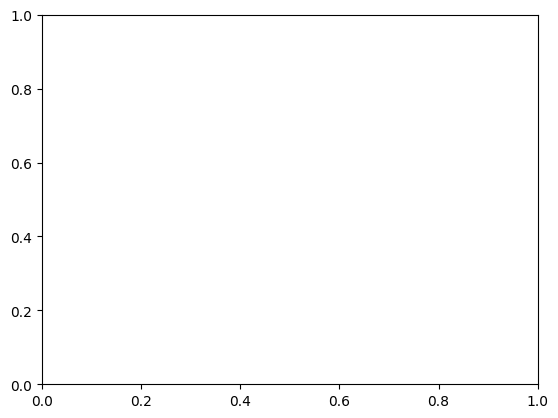

In [71]:
new_molecule_fingerprint = data_features["Morgan_fingerprint"]
predicted_kcat = svm_regressor.predict([new_molecule_fingerprint])

c:\Users\Gilbert\anaconda3\envs\bcb\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


ValueError: setting an array element with a sequence.

In [64]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

# Check data types
print("x_train data type:", type(x_train))
print("y_train data type:", type(y_train))



x_train shape: (3308, 2)
y_train shape: (3308,)
x_train data type: <class 'pandas.core.frame.DataFrame'>
y_train data type: <class 'numpy.ndarray'>


In [65]:
# this initialization of the regression model
rf_regressor = RandomForestRegressor(n_estimators=125, max_depth=35, random_state=42)

rf_regressor.fit(x_train, y_train)

y_pred = rf_regressor.predict(x_test)

In [ ]:
import matplotlib.pyplot as plt

estimators = np.arange(10, 200, 10)
scores = []
for n in estimators:
    rf_regressor.set_params(n_estimators=n)
    rf_regressor.fit(x_train, y_train)
    scores.append(rf_regressor.score(x_test, y_test))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

In [34]:
data.describe()

,EC_number,Species,Kcat
count,4136.000000,4136.000000,4136.000000
mean,237.390957,121.036267,0.206677
std,117.585124,67.214484,1.569205
min,0.000000,0.000000,-5.537602
25%,139.000000,81.000000,-0.853872
50%,238.000000,106.000000,0.302113
75%,350.000000,180.000000,1.356026
max,437.000000,265.000000,4.893762


In [58]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


print('MAE: ', mean_absolute_error(y_test, y_pred))
print('MSE: ', mean_squared_error(y_test, y_pred)) 


MAE:  0.779105936118103
MSE:  1.1654706646310864


In [ ]:
data["Kcat_normalized"].describe()

In [43]:
from sklearn.model_selection import GridSearchCV

# helps finding the optimal hyperparameters
param_grid = {
    'n_estimators': [100,200,250],
    'max_depth': [35, 40, 45]
    # Add more hyperparameters and values
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid=param_grid, cv=3)
grid_search.fit(x_train, y_train)

best_rf_regressor = grid_search.best_estimator_

In [50]:
grid_search.score(x_train, y_train)

0.45295155723117564

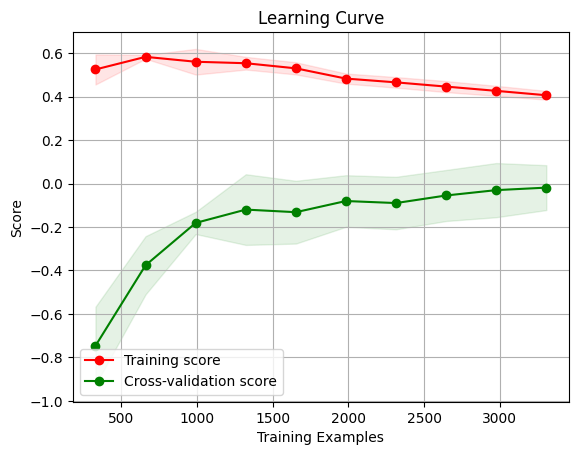

In [49]:
# Create a random forest regressor

from sklearn.model_selection import learning_curve


regressor = RandomForestRegressor(n_estimators=150, max_depth=15, random_state=42)

# Create learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    regressor, x, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation of scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g",
)
plt.plot(
    train_sizes, train_scores_mean, "o-", color="r", label="Training score"
)
plt.plot(
    train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
)

plt.legend(loc="best")
plt.show()
